# Сравнение методов классификации

In [7]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_moons

## Датасет

Нашёл такое (на мой взгляд интересное) составление данных из функции `make_moons`.

In [8]:
def make_sunny_moons(n_sun=50, n_moons=100, noise=0.0, sun_radius=1.9, theta=None):
    X_moons, y_moons = make_moons(n_samples=n_moons, noise=noise, random_state=0xC0FFEE)
    if not n_sun:
        return X_moons, y_moons
    
    rng = np.random.default_rng(0xC0FFEE)
    angles = np.arange(0, 2 * np.pi, 2 * np.pi / n_sun)
    X_sun = sun_radius * np.column_stack([np.cos(angles), np.sin(angles)]) + np.array([0.5, 0.25])
    X_sun += rng.normal(scale=noise, size=X_sun.shape)
    y_sun = 2 * np.ones(n_sun)

    X = np.vstack([X_moons, X_sun])
    y = np.concatenate([y_moons, y_sun]).astype(int)
    X -= X.mean(axis=0)

    if theta is None:
        theta = np.pi / 4
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    X = X @ R
    
    return X, y

In [9]:
X, y = make_sunny_moons(n_sun=150, n_moons=300, noise=0.15)

In [10]:
X,y

(array([[-1.24443661,  1.02671841],
        [ 0.14554925,  1.11594001],
        [-0.12166453, -0.49269419],
        [ 0.21282755, -0.95140342],
        [-0.20061345,  1.10191776],
        [ 0.49686835,  0.54643595],
        [-1.39535142,  0.85873998],
        [-0.29746604,  0.21316148],
        [-0.48913766, -0.33942036],
        [ 1.09650129, -0.98901737],
        [-0.76061856,  1.32020705],
        [-0.05532399,  1.10384277],
        [-0.31860625, -0.39769063],
        [ 0.30190374,  0.89047708],
        [-0.21535248, -0.81808838],
        [ 0.63302446, -1.1226905 ],
        [-0.96650087,  1.10047813],
        [ 0.15004362, -0.95427411],
        [ 0.45368501, -0.22604208],
        [-0.49690196, -0.50481918],
        [ 0.42521497, -1.24836332],
        [-0.31824211, -0.1560206 ],
        [ 0.12086569,  0.90099973],
        [ 0.39557718,  0.75773431],
        [ 1.28709137, -0.99844979],
        [ 0.0114147 ,  0.92983693],
        [ 0.16850093, -0.53247425],
        [-1.07376839,  1.049

In [11]:
X.shape, y.shape

((450, 2), (450,))

In [12]:
pd.DataFrame(X).describe()

,0,1
count,4.500000e+02,4.500000e+02
mean,-1.381611e-17,2.052679e-16
std,9.028434e-01,1.038171e+00
min,-2.141274e+00,-2.179789e+00
25%,-5.374047e-01,-9.401419e-01
50%,1.333108e-02,4.111306e-02
75%,5.339125e-01,9.278842e-01
max,2.226452e+00,2.115157e+00


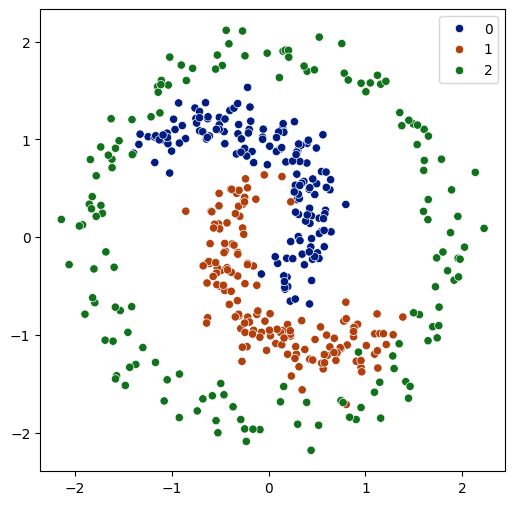

In [13]:
plt.figure(figsize=(6, 6))

sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, palette='dark')

plt.show()

### Что можно понять:
* Присутствуют спирали и окружность. Сами спирали находятся внутри окружности.
* Граница между классами нелинейная.
* Присутствует шум.
* В силу спиральной и круговой структуры распределения данных, мы можем получить достойный результат, если заведем фичи, зависящие от исходных тригонометрически или квадратически.

## Feature Engineering and Model construction

Сделаем функцию для анализа решений классификаторов

In [14]:
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

def make_clf_plot(classifier, axis, title=None):
    classifier.fit(X, y)
    plot_decision_regions(X, y, clf=classifier, legend=2, ax=axis)
    accuracy = accuracy_score(y, classifier.predict(X))
    title = classifier.__class__.__name__ if title is None else title
    axis.set_title(f"{title}, accuracy = {accuracy:2.2f}")

Пример

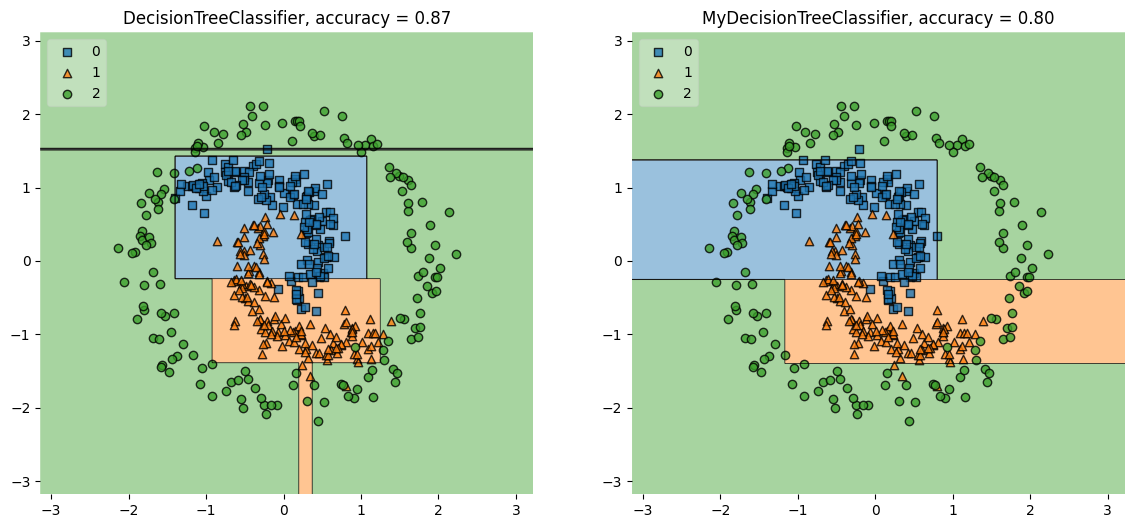

In [15]:
fig, axes = plt.subplots(1,2, figsize=(14, 6))
make_clf_plot(DecisionTreeClassifier(max_depth=4, random_state=42), axes[0])
make_clf_plot(MyDecisionTreeClassifier(max_depth=4, random_state=42), axes[1])

Теперь попробуем реализовать несколько пайплайнов с различными видами классификаторов

In [16]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Добавим такие фичи как синус и косинус исходных признаков. Так же добавим полиномиальные комбинации степени, меньшей 2. Для всех этих данных проведем стандартизацию через `StandardScaler`.

In [17]:
# Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42)),
])

# Random Forest Pipeline
RF_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('tree', RandomForestClassifier(random_state=42)),
])

# Gaussian Naive Bayes Pipeline
GNB_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('gnb', GaussianNB()),
])

# K-Nearest Neighbors Pipeline
KNN_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('knn', KNeighborsClassifier()),
])

Посмотрим, как данные модели разбивают пространство на области

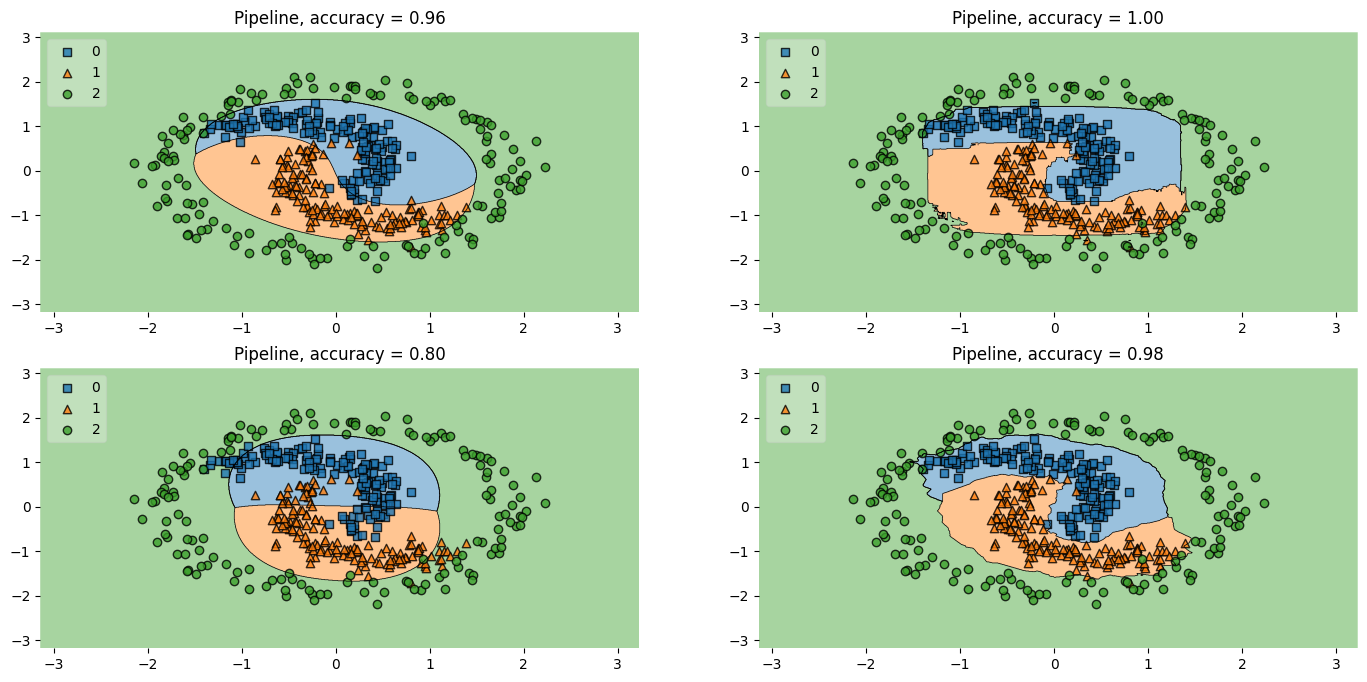

In [18]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(17, 8))

for classifier, axis in zip((logreg_pipeline, RF_pipeline, GNB_pipeline, KNN_pipeline), axes.flat):
    make_clf_plot(classifier, axis)

### Подбор гиперпараметров

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# Parameter grid for Logistic Regression
logreg_param_grid = {
    'logreg__C': [0.25, 0.5, 1, 2, 4, 8],
    'logreg__solver': ['liblinear', 'lbfgs']
}

# Parameter grid for Random Forest
RF_param_grid = {
    'tree__n_estimators': [1, 3, 5, 7, 10, 30, 50, 100, 150],
    'tree__max_depth': [1, 2, 3, 5, 7, 11, 15]
}

# Parameter grid for Gaussian Naive Bayes
GNB_param_grid = {
    'gnb__var_smoothing': [1e-9, 1e-8, 1e-7]
}

# Parameter grid for K-Nearest Neighbors
KNN_param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['l1', 'l2']
}

In [22]:
# GridSearchCV for Logistic Regression
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=5, scoring='accuracy')
logreg_grid_search.fit(X_train, y_train)
print("Best parameters for Logistic Regression:", logreg_grid_search.best_params_)
print("Best score for Logistic Regression:", logreg_grid_search.best_score_)

Best parameters for Logistic Regression: {'logreg__C': 4, 'logreg__solver': 'lbfgs'}
Best score for Logistic Regression: 0.9615013169446882


In [23]:
# GridSearchCV for Random Forest
RF_grid_search = GridSearchCV(RF_pipeline, RF_param_grid, cv=5, scoring='accuracy')
RF_grid_search.fit(X_train, y_train)
print("Best parameters for Random Forest:", RF_grid_search.best_params_)
print("Best score for Random Forest:", RF_grid_search.best_score_)

Best parameters for Random Forest: {'tree__max_depth': 11, 'tree__n_estimators': 100}
Best score for Random Forest: 0.9615452151009658


/home/dmitr/programs/spbu-python-course/pyenv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [24]:
# GridSearchCV for Gaussian Naive Bayes
GNB_grid_search = GridSearchCV(GNB_pipeline, GNB_param_grid, cv=5, scoring='accuracy')
GNB_grid_search.fit(X_train, y_train)
print("Best parameters for Gaussian Naive Bayes:", GNB_grid_search.best_params_)
print("Best score for Gaussian Naive Bayes:", GNB_grid_search.best_score_)

Best parameters for Gaussian Naive Bayes: {'gnb__var_smoothing': 1e-09}
Best score for Gaussian Naive Bayes: 0.7865671641791044


In [25]:
# GridSearchCV for K-Nearest Neighbors
KNN_grid_search = GridSearchCV(KNN_pipeline, KNN_param_grid, cv=5, scoring='accuracy')
KNN_grid_search.fit(X_train, y_train)
print("Best parameters for K-Nearest Neighbors:", KNN_grid_search.best_params_)
print("Best score for K-Nearest Neighbors:", KNN_grid_search.best_score_)

Best parameters for K-Nearest Neighbors: {'knn__metric': 'l1', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Best score for K-Nearest Neighbors: 0.9614135206321335


In [26]:
%time
y_pred_logreg = logreg_grid_search.predict(X_test)

CPU times: user 18 μs, sys: 0 ns, total: 18 μs
Wall time: 88.9 μs


In [27]:
%time
y_pred_rf = RF_grid_search.predict(X_test)

CPU times: user 7 μs, sys: 0 ns, total: 7 μs
Wall time: 11.7 μs


In [28]:
%time
y_pred_gnb = GNB_grid_search.predict(X_test)

CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 10 μs


In [29]:
%time
y_pred_knn = KNN_grid_search.predict(X_test)

CPU times: user 5 μs, sys: 1 μs, total: 6 μs
Wall time: 10.3 μs


In [30]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

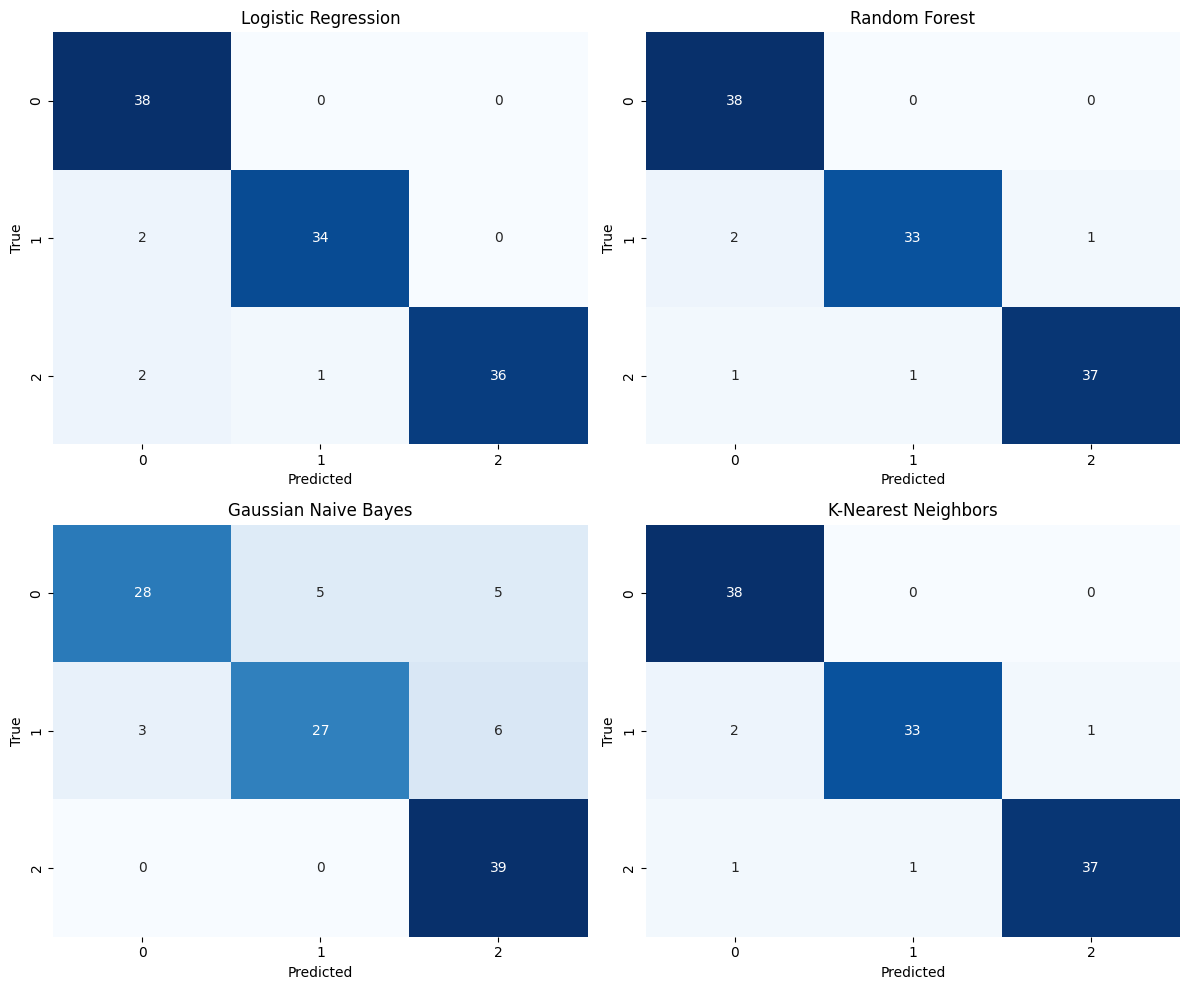

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_confusion_matrix(y_test, y_pred_logreg, axes[0, 0], 'Logistic Regression')

plot_confusion_matrix(y_test, y_pred_rf, axes[0, 1], 'Random Forest')

plot_confusion_matrix(y_test, y_pred_gnb, axes[1, 0], 'Gaussian Naive Bayes')

plot_confusion_matrix(y_test, y_pred_knn, axes[1, 1], 'K-Nearest Neighbors')

plt.tight_layout()
plt.show()

## Вывод

1. `Logistic Regression` показал отличные результаты метрики `accuracy` на кросс-валидации, проведенной внутри функции `GridSearch`. Это говорит о высоком качестве данной модели.
2. `Random Forest` Показывает лучшие результаты c незначительным количеством ошибок предсказания. Это говорит о высоком качестве модели.
3. `Gaussian Naive Bayes` Показал худшие результаты среди всех рассмотренных моделей. Одной из причин может быть не нормальное распределение данных. Так же предположение о независимости признаков может быть ложным, что делает работу данной модели непредсказуемой.
4. `K-Nearest Neighbors` показал отличные результаты, наравне с моделью `Logistic Regression`. Это говорит о высоком качестве модели.

## Самописный классификатор - Decision Tree

In [32]:
import enum
import typing as tp

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import mode


class NodeType(enum.Enum):
    REGULAR = 1
    TERMINAL = 2

In [33]:
class MyDecisionTreeNode:
    def __init__(self, meta: 'MyDecisionTreeClassifier', depth, node_type: NodeType = NodeType.REGULAR,
                 predicted_class: tp.Optional[int] = None, left_subtree: tp.Optional['MyDecisionTreeNode'] = None,
                 right_subtree: tp.Optional['MyDecisionTreeNode'] = None, feature_id: int = None, threshold: float | None = None,
                 impurity: float = np.inf):
        self._meta = meta
        self._depth = depth
        self._node_type = node_type
        self._predicted_class = predicted_class
        self._left_subtree = left_subtree
        self._right_subtree = right_subtree
        self._feature_id = feature_id
        self._threshold = threshold
        self._impurity = impurity
        self._class_proba : np.ndarray | None = None
    
    def _gini(self, y: np.ndarray) -> float:
        """
        Computes Gini index for given set of labels
        :param y: labels
        :return: Gini impurity
        """
        class_counts = np.bincount(y)
        class_prob = class_counts / len(y)
        gini_index = 1 - np.sum(class_prob ** 2)
        return gini_index

    def _weighted_impurity(self, y_left: np.ndarray, y_right: np.ndarray) -> tp.Tuple[float, float, float]:
        """
        Computes weighted impurity by averaging children impurities
        :param y_left: left partition
        :param y_right: right partition
        :return: averaged impurity, left child impurity, right child impurity
        """
        left_impurity = self._gini(y_left)
        right_impurity = self._gini(y_right)
        weighted_impurity = len(y_left) / (len(y_left) + len(y_right)) * left_impurity + len(y_right) / (len(y_left) + len(y_right)) * right_impurity
        return weighted_impurity, left_impurity, right_impurity

    def _create_split(self, feature_values: np.ndarray, threshold: float) -> tp.Tuple[np.ndarray, np.ndarray]:
        """
        Splits given 1-d array according to relation to threshold into two subarrays
        :param feature_values: feature values extracted from data
        :param threshold: value to compare with
        :return: two sets of indices
        """
        left_idx = np.where(feature_values <= threshold)[0]
        right_idx = np.where(feature_values > threshold)[0]
        return left_idx, right_idx
    
    def _best_split(self, X: np.ndarray, y: np.ndarray):
        """
        Finds best split
        :param X: Data, passed to node
        :param y: labels
        :return: best feature, best threshold, left child impurity, right child impurity
        """
        lowest_impurity = np.inf
        best_feature_id = None
        best_threshold = None
        lowest_left_child_impurity, lowest_right_child_impurity = None, None
        features = self._meta.rng.permutation(X.shape[1])

        for feature in features:
            current_feature_values = X[:, feature]
            thresholds = np.unique(current_feature_values)

            for threshold in thresholds:
                left_idx, right_idx = self._create_split(current_feature_values, threshold)

                if len(left_idx) == 0 or len(right_idx) == 0:
                    continue

                current_weighted_impurity, current_left_impurity, current_right_impurity = self._weighted_impurity(y[left_idx], y[right_idx])

                if current_weighted_impurity < lowest_impurity:
                    lowest_impurity = current_weighted_impurity
                    best_feature_id = feature
                    best_threshold = threshold
                    lowest_left_child_impurity = current_left_impurity
                    lowest_right_child_impurity = current_right_impurity

        return best_feature_id, best_threshold, lowest_left_child_impurity, lowest_right_child_impurity

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Recursively fits a node, providing it with predicted class or split condition
        :param X: Data
        :param y: labels
        :return: fitted node
        """
        if len(np.unique(y)) == 1 or len(y) < self._meta.min_samples_split or self._depth >= self._meta.max_depth:
            self._node_type = NodeType.TERMINAL
            mode_result = mode(y, keepdims=True)
            self._predicted_class = mode_result.mode[0]
            self._class_proba = np.bincount(y, minlength=self._meta._n_classes) / len(y)
            return self

        self._feature_id, self._threshold, left_imp, right_imp = self._best_split(X, y)

        left_idx, right_idx = self._create_split(X[:, self._feature_id], self._threshold)

        self._left_subtree = MyDecisionTreeNode(
            meta=self._meta,
            depth=self._depth + 1,
            impurity=left_imp
        ).fit(X[left_idx], y[left_idx])

        self._right_subtree = MyDecisionTreeNode(
            meta=self._meta,
            depth=self._depth + 1,
            impurity=right_imp
        ).fit(X[right_idx], y[right_idx])

        return self

    def predict(self, x: np.ndarray):
        """
        Predicts class for a single object
        :param x: object of shape (n_features, )
        :return: class assigned to object
        """
        if self._node_type is NodeType.TERMINAL:
            return self._predicted_class

        if x[self._feature_id] <= self._threshold:
            return self._left_subtree.predict(x)
        else:
            return self._right_subtree.predict(x)

    def predict_proba(self, x: np.ndarray):
        """
        Predicts probability for a single object
        :param x: object of shape (n_features, )
        :return: vector of probabilities assigned to object
        """
        if self._node_type is NodeType.TERMINAL:
            return self._class_proba

        if x[self._feature_id] <= self._threshold:
            return self._left_subtree.predict_proba(x)
        else:
            return self._right_subtree.predict_proba(x)

In [34]:
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    """
    Class analogous to sklearn implementation of decision tree classifier with Gini impurity criterion
    """

    def __init__(self, max_depth: tp.Optional[int] = None, min_samples_split: tp.Optional[int] = 2, random_state: int = 0):
        """
        :param max_depth: maximal depth of tree, prevents overfitting
        :param min_samples_split: minimal amount of samples for node to be a splitter node
        :param random_state: random_state for RNG, enables reproducibility
        """
        self.root = MyDecisionTreeNode(self, 1)
        self._is_trained = False
        self.max_depth = max_depth or np.inf
        self.min_samples_split = min_samples_split or 2
        self.random_state = random_state
        self.rng = np.random.default_rng(random_state)
        self._n_classes = 0

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Starts recursive process of node criterion fitting from the root
        :param X: Data
        :param y: labels
        :return: fitted self
        """
        self._n_classes = np.unique(y).shape[0]
        self.classes_ = np.unique(y)
        self.root.fit(X, y)
        self._is_trained = True
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts class for a sequence of objects
        :param X: Data
        :return: classes assigned to each object
        """
        if not self._is_trained:
            raise RuntimeError('predict call on untrained model')

        predictions = np.array([self.root.predict(x) for x in X])
        return predictions

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts class probabilities for a sequence of objects
        :param X: Data
        :return: probabilities of all classes for each object
        """
        if not self._is_trained:
            raise RuntimeError('predict_proba call on untrained model')

        probas = np.array([self.root.predict_proba(x) for x in X])
        return probas

In [35]:
my_DT_pipeline = Pipeline([
    ('feature_generation', FeatureUnion([
        ('sine', FunctionTransformer(np.sin)),
        ('cosine', FunctionTransformer(np.cos)),
        ('id', FunctionTransformer())
    ])),
    ('polynomial', PolynomialFeatures(2)),
    ('standartization', StandardScaler()),
    ('model', MyDecisionTreeClassifier())
])

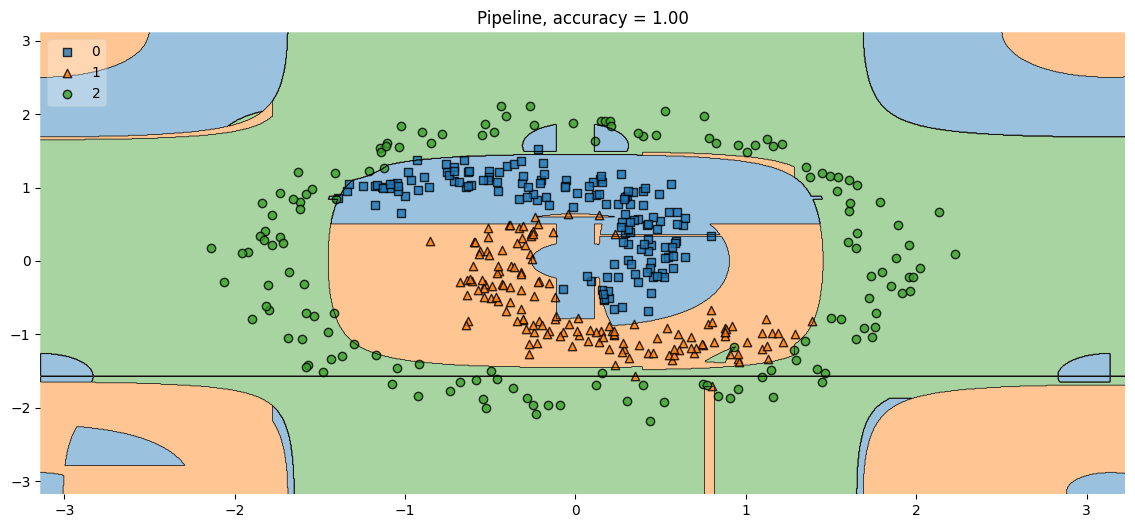

In [36]:
fig, axis = plt.subplots(1,1, figsize=(14, 6))
make_clf_plot(my_DT_pipeline, axis)

In [37]:
# Parameter grid for Random Forest
my_DT_param_grid = {
    'model__max_depth': [3, 5, 7, 10, 15]
}

In [38]:
# GridSearchCV for My Random Forest Regression
my_DT_grid_search = GridSearchCV(my_DT_pipeline, my_DT_param_grid, cv=5, scoring='accuracy')
my_DT_grid_search.fit(X_train, y_train)
print("Best parameters for my Decision Tree:", my_DT_grid_search.best_params_)
print("Best score for my Decision Tree:", my_DT_grid_search.best_score_)

Best parameters for my Decision Tree: {'model__max_depth': 7}
Best score for my Decision Tree: 0.9318261633011413


In [39]:
%time
y_pred_my_DT = my_DT_grid_search.predict(X_test)

CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 5.48 μs


In [40]:
accuracy_score(y_test,y_pred_my_DT)

0.9380530973451328

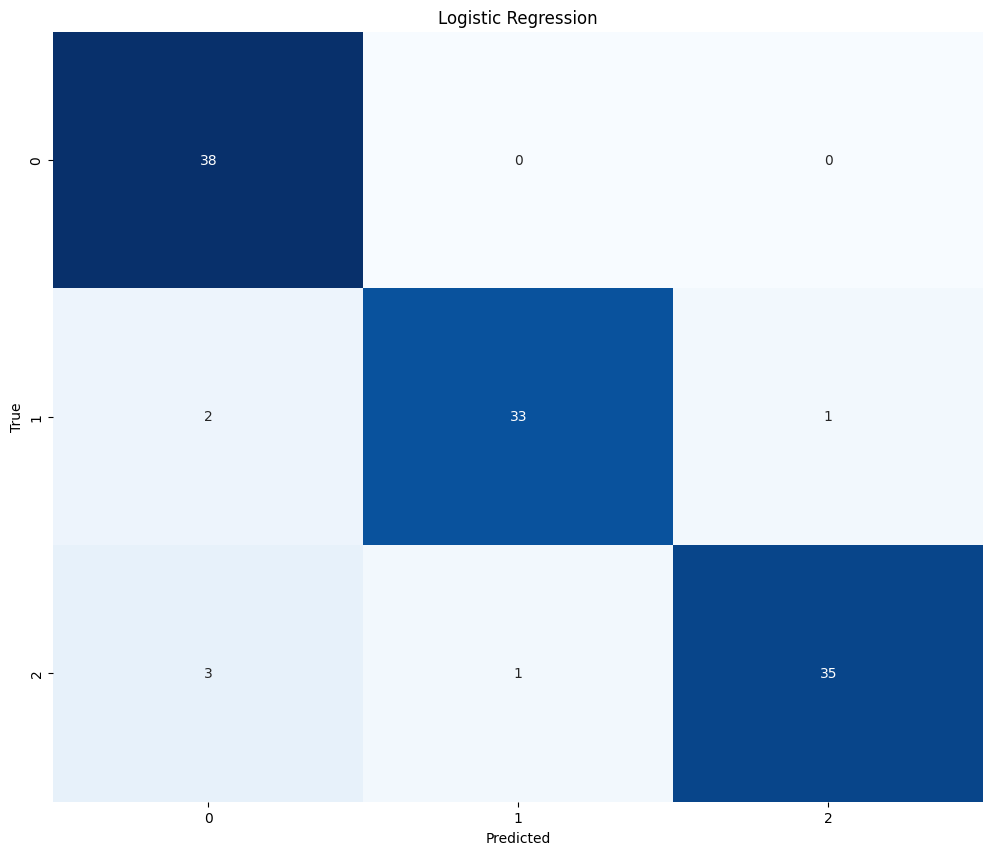

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(12, 10))
plot_confusion_matrix(y_test, y_pred_my_DT, axes, 'Logistic Regression')

### Вывод:

Самописный `Decision Tree` показывает хорошие результаты на задаче классификации точек. Данный классификатор справляется с задачей на 3 сотых `accuracy` хуже, чем `Logistic Regression`, `RandomForestClassifier`, и `KNN`, но лучше чем `Gaussian Naive Bayes`.